Warning: this notebook takes at least an hour to run on a 2017 MacBook Pro.  However, the output of Figure 3 has been saved towards the end of the notebook, along with a few other outputs after the output of Figure 3

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pyfftw.interfaces.numpy_fft import fft, fftshift, ifft, ifftshift, fftfreq
import os

In [3]:
import ufss

In [4]:
folder = 'Suess2019System'
os.makedirs(folder,exist_ok=True)

Note: this notebook generates Figure 3 (the first plot that appears in this notebook), along with plots comparing the impulsive limit to 5 fs pulses, and the impulsive limit to 15 fs pulses

## Defining the material system

### Hamiltonian

First we set up the Hamiltonian presented in https://doi.org/10.1063/1.5086151

In [5]:
def basis(row,col):
    """inds should be a tuple defining a single entry to be 1"""
    shape = (3,3)
    arr = np.zeros(shape)
    arr[(row,col)] = 1
    return arr

In [ ]:
#useful conversion
ev_to_THz = 1/4.1357E-15/1E12
ev_to_THz

In [7]:
# ground, 1st and 2nd excited states for monomer
g = basis(0,0)
e = basis(1,1)
f = basis(2,2)

# other useful operators for monomer
eg = basis(1,0)
fe = basis(2,1)
fg = basis(2,0)
eye = np.eye(3)

# acts on a monomer ket to move up the ladder of the 3LS
up = eg + fe

# acts on a dimer ket to move up the ladder of optical excitations
total_up = np.kron(up,eye) + np.kron(eye,up)

# in the reference paper the dipole transition magnitude for a monomer is the same
# value for the transition from g -> e and from e -> f.  Therefore
mu_up = total_up

# the full dipole operator is
mu = mu_up + mu_up.T
# however, we use mu_up and mu_up.T separately in order to impose the rotating wave approximation (RWA)

# Hamiltonian Parameters, all in eV, multiplied by a conversion to THz
e_g = 0
e_e = 1
e_f = 2.2

J = 0.2
K = 0.1
L = 0.05

E_gg = e_g + e_g
E_ee = e_e + e_e
E_eg = e_e + e_g
E_fg = e_f + e_g
E_fe = e_f + e_e
E_ff = e_f + e_f

Constructing Hamiltonian using Eqs. 1-5 from ref. paper

In [ ]:
H0 = E_gg * np.kron(g,g)

H1_diag = E_eg * (np.kron(e,g) + np.kron(g,e))
H1_off = J * (np.kron(eg,eg.T))
H1_off = H1_off + np.conjugate(H1_off.T)
H1 = H1_diag + H1_off

H2_diag = E_ee * np.kron(e,e) + E_fg * (np.kron(f,g) + np.kron(g,f))
H2_off =  K * (np.kron(fe,eg.T) + np.kron(eg.T,fe))
H2_off = H2_off + np.conjugate(H2_off.T)
H2 = H2_diag + H2_off

H3_diag = E_fe * (np.kron(f,e) + np.kron(e,f))
H3_off = L * (np.kron(fe,fe.T))
H3_off = H3_off + np.conjugate(H3_off.T)
H3 = H3_diag + H3_off

H4 = E_ff * np.kron(f,f) #not relevant, and not seen in reference paper, but included for completeness
H = H0 + H1 + H2 + H3 + H4
print(H)

Following the reference paper, we construct the bath and coupling in the eigenbasis of the Hamiltonian

In [ ]:
# eigenbasis of Hamiltonian
q,v = np.linalg.eigh(H)
for i in range(q.size):
    max_ind = np.argmax(np.abs(v[:,i]))
    if v[max_ind,i] < 0:
        # pick phase of each eigenvector
        v[:,i] = v[:,i]*-1
print(np.round(q,5),'\n')
print(np.round(v,3))

Define Hamiltonian in its own eigenbasis

In [ ]:
H_diag = np.diag(q)
II = np.eye(H_diag.shape[0])
print(np.round(H_diag,2))

In [ ]:
# the dipole operator transforms into the eigenbasis as
mu_up_eigen = v.T.dot(mu_up.dot(v))
print(np.round(mu_up_eigen,2))

In [ ]:
psi_g = np.zeros(H_diag.shape[0])
psi_g[0] = 1
psi_e = mu_up_eigen.dot(psi_g)
#print(np.where(np.isclose(psi_e,0)))
psi_d = mu_up_eigen.dot(psi_e)
print(np.where(np.isclose(psi_d,0)))

In [ ]:
# Thus the doubly-excited wavefunction is composed of two eigenstates (the third is dark)
# They are separated by an energy difference of
print(q[5]-q[3])

At this point we have enough information to save the relevant inputs for calculating spectra for closed systems, except that we need to understand how the indices for the excitation manifolds have changed

### Liouvillian

We begin constructing the Liouvillian that describes the open quantum system by starting with the unitary evolution

In [14]:
L_closed = -1j*np.kron(H_diag,II.T) + 1j*np.kron(II,H_diag.T)

The reference paper uses the stochastic Schrodinger equation.  We adapt this approach using the Lindblad formalism. 

They begin with separate rates for the monomer relaxation process f $\rightarrow$ e ($k_M$) and e $\rightarrow$ g ($\tilde{k}_M$)

In [15]:
# Relaxation parameter is 0.015 fs^-1, so in THz that is
0.015 * 1000
# and in eV radians that is
kM = 0.015 * 1000 / ev_to_THz / (2*np.pi)

# I also need to include relaxation to the ground state, in order to avoide multiple 0 eigenvalues.
# I will make it 10^3 times less to avoid having it make an appreciable contribution to the spectra
# This is actually set to 0 in the paper
kMtilde = kM/1E3

They define the stochastic jump operators in the eigenbasis, with rates defined in Eq. 25 of the ref paper.

In [16]:
def ktildenm(n,m):
    vn = v[:,n]
    vm = v[:,m]
    vnstar = np.conjugate(vn)
    vmstar = np.conjugate(vm)
    rate = (vnstar.dot(np.kron(e,g)).dot(vn)*vmstar.dot(np.kron(g,g)).dot(vm)
            +vnstar.dot(np.kron(g,e)).dot(vn)*vmstar.dot(np.kron(g,g)).dot(vm)
            +vnstar.dot(np.kron(e,e)).dot(vn)*vmstar.dot(np.kron(e,g)).dot(vm)
            +vnstar.dot(np.kron(e,e)).dot(vn)*vmstar.dot(np.kron(g,e)).dot(vm))
    return rate

def knm(n,m):
    vn = v[:,n]
    vm = v[:,m]
    vnstar = np.conjugate(vn)
    vmstar = np.conjugate(vm)
    rate = (vnstar.dot(np.kron(f,g)).dot(vn)*vmstar.dot(np.kron(e,g)).dot(vm)
            +vnstar.dot(np.kron(g,f)).dot(vn)*vmstar.dot(np.kron(g,e)).dot(vm)
            +vnstar.dot(np.kron(f,e)).dot(vn)*vmstar.dot(np.kron(e,e)).dot(vm)
            +vnstar.dot(np.kron(e,f)).dot(vn)*vmstar.dot(np.kron(e,e)).dot(vm)
            +vnstar.dot(np.kron(f,f)).dot(vn)*vmstar.dot(np.kron(f,e)).dot(vm)
            +vnstar.dot(np.kron(f,f)).dot(vn)*vmstar.dot(np.kron(e,f)).dot(vm))
    return rate

In [17]:
eigendecay = np.zeros((9,9))
eigendecaytilde = np.zeros((9,9))
for i in range(9):
    for j in range(9):
        eigendecaytilde[j,i] = ktildenm(i,j)*kMtilde
        eigendecay[j,i] = knm(i,j)*kM
eigen_relaxation = eigendecay + eigendecaytilde

In [18]:
# Zero-temperature
decay_instructions = []
zero_decay_instructions = []
for i in range(9):
    for j in range(9):
        rate = eigen_relaxation[i,j] #* 2 #Factor of 2 comes from definition of Lindblad rates
        decay_operator = np.zeros((9,9))
        decay_operator[i,j] = 1
        ins = ufss.vibronic_eigenstates.OpenPolymer.make_Lindblad_instructions(rate,decay_operator)
        decay_instructions += ins

D = ufss.vibronic_eigenstates.OpenPolymer.make_Liouvillian(decay_instructions)
L = L_closed + D

In [ ]:
manL = ufss.vibronic_eigenstates.ManualL(L,mu_up_eigen,savedir=folder,output='uf2')

## EEI2D spectroscopy

In [ ]:
# I set hbar to 1, or I divide everything by hbar, find the natural frequency associated with E_eg, 
# and take that as omega_0. So in actuality, we have that omega_0 is
omega_0 = 1*ev_to_THz*(2*np.pi) # in rad/(10^12s)
omega_0

In [ ]:
# In fs, the period is
2*np.pi/omega_0*1E3

In [ ]:
# In the reference paper, they consider tau out to 823 fs.  In terms of omega0^-1, that is
inverse_omega_0 = 1E3/omega_0
tfinal = 823/inverse_omega_0
# They do not specify a step size, but I have found that a step size of 3 fs works well
t_step = 3/inverse_omega_0
print(tfinal,t_step)

In [23]:
# calculations
open_calc_folder = os.path.join(folder,'uf2')

eei2d_true_imp = ufss.DensityMatrices(open_calc_folder,detection_type='complex_polarization')
eei2d_5fs = ufss.DensityMatrices(open_calc_folder,detection_type='complex_polarization')
eei2d_5fs_time_ordered = ufss.DensityMatrices(open_calc_folder,detection_type='complex_polarization')
eei2d_15fs = ufss.DensityMatrices(open_calc_folder,detection_type='complex_polarization')
eei2d_15fs_time_ordered = ufss.DensityMatrices(open_calc_folder,detection_type='complex_polarization')

In [24]:
# use gaussian pulse shape
pulse_shape = ufss.efield_shapes.gaussian

c = 1

# setting the local oscillator also sets the t-mesh step size
lo_t =  np.arange(-5,5.02,1)*t_step
lo_dt = lo_t[1] - lo_t[0]
lo = np.zeros(lo_t.size,dtype='float')
lo[lo.size//2] = 1/lo_dt
lo_t = np.array([0])
lo = [1]

def setup(spec_obj,fwhm_fs):
    """Setup a closed or open spectroscopy object for calculations"""
    spec_obj.fwhm_fs = fwhm_fs
    fwhm = fwhm_fs/inverse_omega_0
    sigma = fwhm/(2*np.sqrt(2*np.log(2)))
    
    t = np.arange(-5,5.002,0.1)*sigma
    dt = t[1] - t[0]
    ef = pulse_shape(t,sigma)
    
    
    spec_obj.set_polarization_sequence(['x','x','x','x'])
    spec_obj.set_efields([t,t,t,lo_t],[ef,ef,ef,lo],[c,c,c,c],[(0,2),(2,0),(1,0)])
    spec_obj.gamma_res = tfinal
    spec_obj.set_t(1,dt=t_step) #set t array (only thing here that I think is opaque)
    spec_obj.pulse_times = [0,0,0]
    
def imp_setup(spec_obj):
    """Setup a closed or open spectroscopy object for calculations"""
    spec_obj.fwhm_fs = 0
    
    t = np.array([0])
    ef = [1]
    
    
    spec_obj.set_polarization_sequence(['x','x','x','x'])
    spec_obj.set_efields([t,t,t,lo_t],[ef,ef,ef,lo],[c,c,c,c],[(0,2),(2,0),(1,0)])
    spec_obj.gamma_res = tfinal
    spec_obj.set_t(1,dt=t_step) #set t array (only thing here that I think is opaque)
    spec_obj.pulse_times = [0,0,0]

imp_setup(eei2d_true_imp)
setup(eei2d_5fs,5)
setup(eei2d_5fs_time_ordered,5)
setup(eei2d_15fs,15)
setup(eei2d_15fs_time_ordered,15)

In [25]:
tau = eei2d_true_imp.t.copy() # use same grid for tau as for t
tau = tau[tau.size//2:] # only simulate positive values of tau

T = np.arange(0,350/inverse_omega_0,t_step/4)
# we do not plot the T-dependence at 5 fs, so no need to do unnecessary calculations
T_5fs = np.array([0])

# The impulsive limit is invalid unless pulses do not overlap at all

delay_offsets = 1E-10#imp_pulse_sigma*20

true_imp_tau = eei2d_true_imp.t.copy() + delay_offsets
true_imp_tau = true_imp_tau[true_imp_tau.size//2:] # only simulate positive values of tau

true_imp_T = T+delay_offsets

eei2d_true_imp.set_pulse_delays([true_imp_tau,true_imp_T])

eei2d_5fs.set_pulse_delays([tau,T_5fs])
eei2d_5fs_time_ordered.set_pulse_delays([tau,T_5fs])

eei2d_15fs.set_pulse_delays([tau,T])
eei2d_15fs_time_ordered.set_pulse_delays([tau,T])

In [ ]:
da = ufss.DiagramGenerator()
#set the times for which the electric fields are non-zero
t = np.arange(-3,3.2,0.25)
da.efield_times = [t,t,t]
#sete the phase-matching condition
da.set_phase_discrimination([(0,2),(2,0),(1,0)])
#Now input delay times for which the pulses are definitely not overlapping
time_ordered_diagrams = da.get_diagrams([0,1000,2000,2000])
# Here they are in the format UFSS uses
for diagram in time_ordered_diagrams:
    print(diagram)

In [ ]:
# only useful for wavefunction calculations
closed_time_ordered_diagrams = da.convert_rho_instructions_list_to_psi_instructions_list(time_ordered_diagrams)
for diagram in closed_time_ordered_diagrams:
    print(diagram)

### Run calculations

In [28]:
# Impulsive calculation
open_signal = eei2d_true_imp.calculate_diagrams_all_delays(time_ordered_diagrams)

eei2d_true_imp.save('Impulsive',['tau','T'])

In [29]:
# 15 fs FWHM pulses
open_signal = eei2d_15fs_time_ordered.calculate_diagrams_all_delays(time_ordered_diagrams)
open_signal = eei2d_15fs.calculate_signal_all_delays()

eei2d_15fs.save('Full_15fs_fwhm',['tau','T'])
eei2d_15fs_time_ordered.save('Time-ordered_15fs_fwhm',['tau','T'])

In [30]:
c = 1
eei2d_true_imp.load('Impulsive.npz',['tau','T'])
eei2d_15fs.load('Full_15fs_fwhm.npz',['tau','T'])
eei2d_15fs_time_ordered.load('Time-ordered_15fs_fwhm.npz',['tau','T'])
tau,T = eei2d_15fs.all_pulse_delays

Following ref paper we add a gaussian linewidth to the spectra

In [31]:
def gaussian_window(obj,linewidth_sigma):
    """Takes in a calculation object, and returns the 2D correlation spectrum with a gaussian window applied"""
    t, sig_tau_T_t = ufss.signals.signal_processing.SignalProcessing.ft1D(obj.w,obj.signal[:,:,:],axis=-1)
    sig_tau_T_t *= (np.exp(-tau**2/(2*linewidth_sigma**2))[:,np.newaxis,np.newaxis] 
                  * np.exp(-t**2/(2*linewidth_sigma**2))[np.newaxis,np.newaxis,:])
    sig_tau_T_t = sig_tau_T_t[...,t.size//2:]
    wt, smeared_sig_tau_T_wt = ufss.signals.signal_processing.SignalProcessing.ift1D(t[t.size//2:],sig_tau_T_t,axis=-1)
    wtau, smeared_sig_wtau_T_wt = ufss.signals.signal_processing.SignalProcessing.ft1D(tau,smeared_sig_tau_T_wt,axis=0)
    return wtau, wt, smeared_sig_wtau_T_wt

In [32]:
gauss_blur = 200/inverse_omega_0
wtau_arr, wt_arr, sig3D_true_imp = gaussian_window(eei2d_true_imp,gauss_blur)
wtau_arr, wt_arr, sig3D_15fs_time_ordered = gaussian_window(eei2d_15fs_time_ordered,gauss_blur)
wtau_arr, wt_arr, sig3D_15fs = gaussian_window(eei2d_15fs,gauss_blur)

In [ ]:
dwt = wt_arr[1] - wt_arr[0]
dwt # pixel size in both omega_t and omega_tau directions

### Useful functions for plotting

In [34]:
def draw_box(ax,center,full_pixel_width,color='k',linestyle='solid'):
    hw = full_pixel_width//2*dwt
    xa = center[0] - hw
    xb = center[0] + hw
    ya = center[1] - hw
    yb = center[1] + hw
    ax.plot([xa,xb],[ya,ya],color=color,linewidth=0.5,linestyle=linestyle)
    ax.plot([xa,xb],[yb,yb],color=color,linewidth=0.5,linestyle=linestyle)
    ax.plot([xa,xa],[ya,yb],color=color,linewidth=0.5,linestyle=linestyle)
    ax.plot([xb,xb],[ya,yb],color=color,linewidth=0.5,linestyle=linestyle)

def find_local_peak(signal,coords,box_size):
    wtau = coords[0] - 2*c
    wt = coords[1] - 1*c
    wtau_ind = np.argmin(np.abs(wtau_arr-wtau))
    a1 = wtau_ind - box_size//2
    b1 = wtau_ind + box_size//2 + 1
    wt_ind = np.argmin(np.abs(wt_arr-wt))
    a2 = wt_ind - box_size//2
    b2 = wt_ind + box_size//2 + 1
    bool_mask = np.zeros(signal.shape,dtype='bool')
    bool_mask[a1:b1,a2:b2] = True
    local_signal = signal*bool_mask
    max_ind = np.argmax(np.abs(local_signal))
    wtau_max, wt_max = np.unravel_index(max_ind,local_signal.shape)
    wtau = wtau_arr[wtau_max] + 2*c
    wt = wt_arr[wt_max] + 1*c
    return wtau, wt

def get_max_peak_pos(sig3D,wtau_arr,wt_arr):
    max_ind = np.argmax(np.abs(sig3D))
    ind0,ind1,ind2 = np.unravel_index(max_ind,sig3D.shape)
    print(ind1)
    return (wtau_arr[ind0]+2*c,wt_arr[ind2]+1*c)

In [35]:
def rescale_intensity(signal,factor):
    Smax = np.max(np.abs(signal))
    S = signal/Smax
    argS = np.angle(signal)
    logS = np.log10((np.abs(S)+1/factor))+np.log10(factor)
    logS = logS * Smax / np.max(np.abs(logS))
    return logS*np.exp(1j*argS)

def custom_colorbar(scale_function,cmap,cax,*,yticks=[]):
    n = 500
    x = np.arange(2) #dummy variable for x-axis
    y = np.linspace(-1,1,num=n)
    dy = y[1] - y[0]
    z = y
    Z = np.ones((y.size,x.size))*z[:,np.newaxis]
    
    y2 = np.linspace(-1-dy,1+dy,num=n+1) #Fix pcolormesh artifact
    
    cax.pcolormesh(x,y2,Z,cmap=cmap)
    cax.set_ylim([-1,1])
    cax.set_xticks([])
    if yticks:
        pass
    else:
        yticks = cax.get_yticks()
    cax.set_yticks(np.real(scale_function(yticks)))
    cax.set_yticklabels([str(x) for x in yticks])

In [36]:
def plot_smeared_line_cut(obj,sig3D,wtau_arr,wt_arr,wtau,wt,*,ax=None,norm='self',filter_type='box',
                         box_size=10,sigma='auto',part='real'):
    if norm == 'self':
        norm = np.max(np.abs(sig3D))
    smeared_sig_wtau_T_wt = sig3D/norm
    
    wtau_ind,wtau = obj.get_closest_index_and_value(wtau,wtau_arr)
    wt_ind,wt = obj.get_closest_index_and_value(wt,wt_arr)
    
    a = box_size//2
    b = box_size//2 + 1
    
    window_line_cut = smeared_sig_wtau_T_wt[wtau_ind-a:wtau_ind+b,:,wt_ind-a:wt_ind+b]
    line_cut = np.zeros(sig3D.shape[1],dtype='complex')
    for ind1 in range(line_cut.size):
        window_signal = window_line_cut[:,ind1,:]
        max_ind = np.argmax(np.abs(window_signal))
        ind0,ind2 = np.unravel_index(max_ind,window_signal.shape)
        line_cut[ind1] = window_signal[ind0,ind2]

    ylabel = ''
    if part =='real':
        line_cut = np.real(line_cut)
        ylabel = 'Re[S]' + ylabel
    elif part == 'imag':
        line_cut = np.imag(line_cut)
        ylabel = 'Im[S]' + ylabel
    elif part == 'abs':
        line_cut = np.abs(line_cut)
        ylabel = '|S|' + ylabel
        
    if ax == None:
        fig, ax = plt.subplots(1)
    T = obj.all_pulse_delays[1]
    line, = ax.plot(T*inverse_omega_0,line_cut)
    ax.set_xlabel('T (fs)',fontsize=14)
    ax.set_ylabel(ylabel,fontsize=14)
    return line

# Generate Figure 3 from Diagram Generator paper

<IPython.core.display.Javascript object>


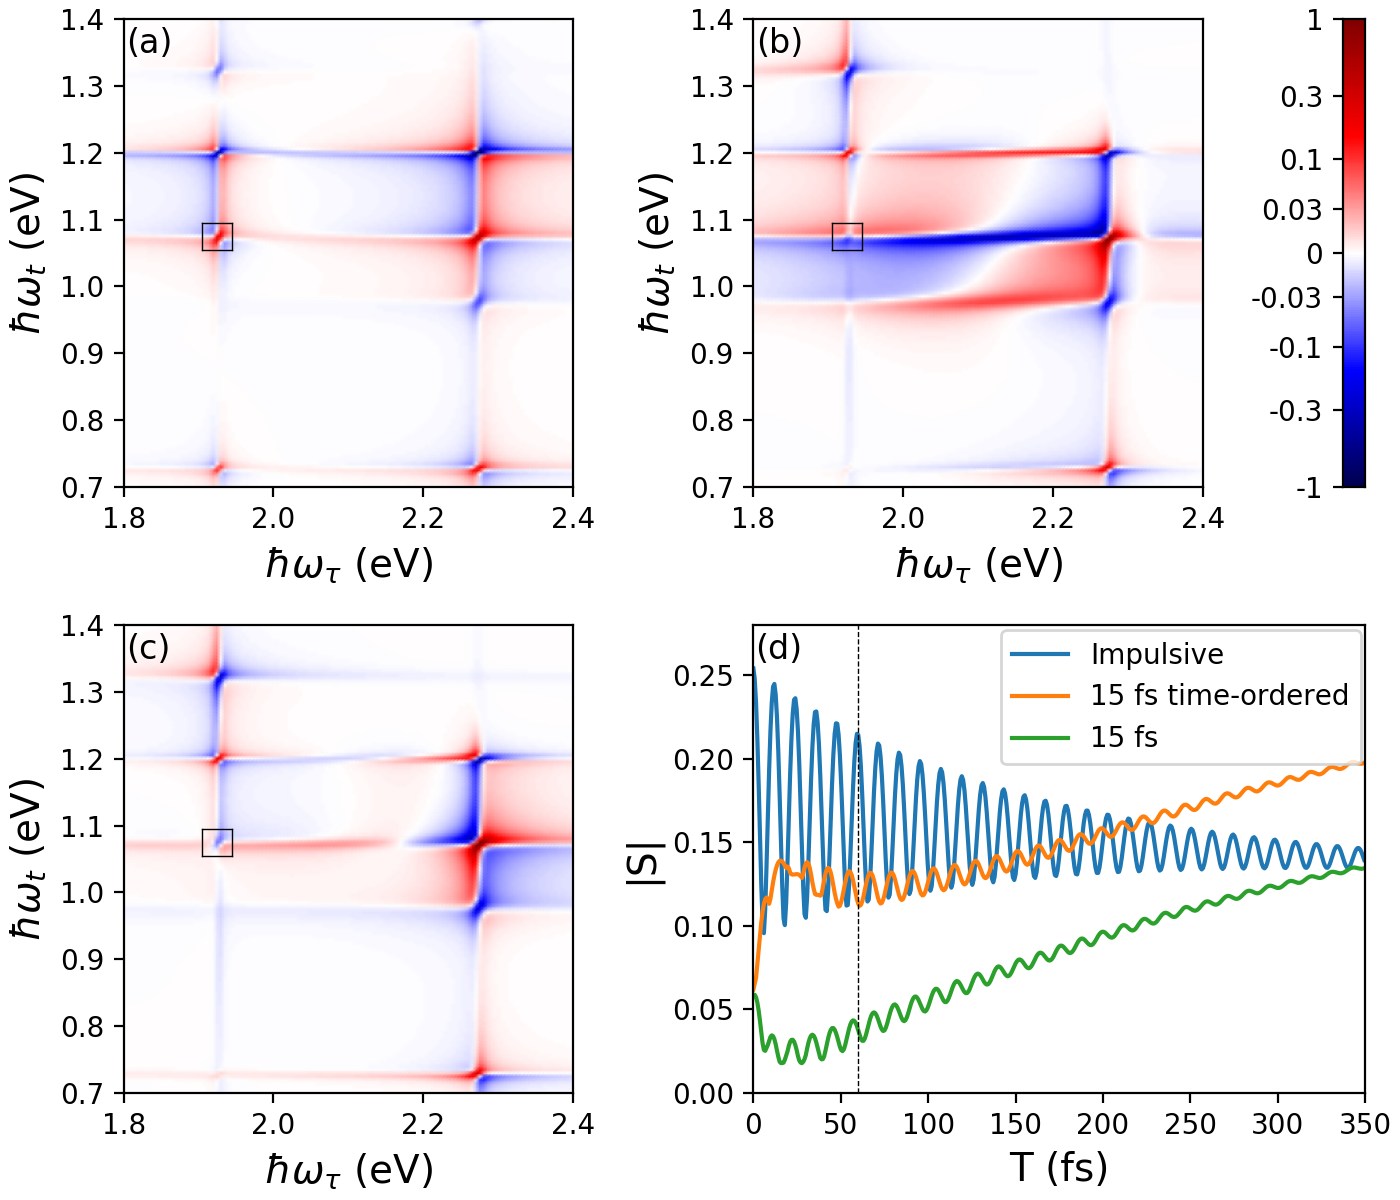

Impulsive calculation time  685.1502101421356
Time-ordered calculation time  1056.8800449371338
Full calculation time  2564.473573207855


In [37]:
part = 'real'

logscale = True
logfactor = 30

T_val = 60/inverse_omega_0
T_ind,T_val = eei2d_true_imp.get_closest_index_and_value(T_val,T)
sig_open_true_imp = sig3D_true_imp[:,T_ind,:]
sig_open_15fs = sig3D_15fs[:,T_ind,:]
sig_open_15fs_time_ordered = sig3D_15fs_time_ordered[:,T_ind,:]


approx_peak_coords = (1.925,1.075)
box_size=8
peak_coords = find_local_peak(sig_open_true_imp,approx_peak_coords,6)

if logscale:
    sig_open_true_imp = rescale_intensity(sig_open_true_imp,logfactor)
    sig_open_15fs = rescale_intensity(sig_open_15fs,logfactor)
    sig_open_15fs_time_ordered = rescale_intensity(sig_open_15fs_time_ordered,logfactor)

    
fig = plt.figure(constrained_layout=True,figsize=(7,6))
widths = [2, 2, 0.1]
heights = [2,2]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths,
                          height_ratios=heights)
axes = []
for col in range(len(widths)):
    ax = fig.add_subplot(spec[0, col])
    axes.append(ax)
axa,axb,axcb = axes
axc = fig.add_subplot(spec[1,0])
axes.append(ax)
axd = fig.add_subplot(spec[1,1:])

ufss.signals.plot2D(wtau_arr+2*c,wt_arr+1*c,sig_open_true_imp,part=part,
                    norm='self',fig=fig,ax=axa,colorbar=False)
print('Impulsive calculation time ',eei2d_true_imp.calculation_time)
axa.set_ylim([0.7,1.4])
axa.set_xlim([1.8,2.4])
axa.set_xlabel(r'$\hbar\omega_\tau$ (eV)',fontsize=14)
axa.set_ylabel(r'$\hbar\omega_t$ (eV)',fontsize=14)
axa.text(1.803,1.35,'(a)',fontsize=12)
draw_box(axa,peak_coords,box_size)

ufss.signals.plot2D(wtau_arr+2*c,wt_arr+1*c,sig_open_15fs_time_ordered,part=part,
                    norm='self',fig=fig,ax=axb,colorbar=False)
print('Time-ordered calculation time ',eei2d_15fs_time_ordered.calculation_time)
axb.set_ylim([0.7,1.4])
axb.set_xlim([1.8,2.4])
axb.set_ylabel(r'$\hbar\omega_t$ (eV)',fontsize=14)
axb.set_xlabel(r'$\hbar\omega_\tau$ (eV)',fontsize=14)
axb.text(1.803,1.35,'(b)',fontsize=12)
draw_box(axb,peak_coords,box_size)

ufss.signals.plot2D(wtau_arr+2*c,wt_arr+1*c,sig_open_15fs,part=part,
                    norm='self',fig=fig,ax=axc,colorbar=False)
if logscale:
    f = lambda x: rescale_intensity(x,logfactor)
else:
    f = lambda x: x
custom_colorbar(f,'seismic',axcb,yticks=[-1,-0.3,-0.1,-0.03,0,0.03,0.1,0.3,1])

print('Full calculation time ',eei2d_15fs.calculation_time)
axc.set_ylim([0.7,1.4])
axc.set_xlim([1.8,2.4])
axc.set_xlabel(r'$\hbar\omega_\tau$ (eV)',fontsize=14)
axc.set_ylabel(r'$\hbar\omega_t$ (eV)',fontsize=14)
axc.text(1.803,1.35,'(c)',fontsize=12)
draw_box(axc,peak_coords,box_size)

part='abs'
local_peak_coords = find_local_peak(sig_open_true_imp,peak_coords,6)

wtau_val = local_peak_coords[0]-2*c
wt_val = local_peak_coords[1]-1*c
line0 = plot_smeared_line_cut(eei2d_true_imp,sig3D_true_imp,wtau_arr, wt_arr,wtau_val,wt_val,ax=axd,
                     part=part,filter_type='box',box_size=box_size)

local_peak_coords = find_local_peak(sig_open_15fs_time_ordered,peak_coords,6)

wtau_val = local_peak_coords[0]-2*c
wt_val = local_peak_coords[1]-1*c
line1 = plot_smeared_line_cut(eei2d_15fs_time_ordered,sig3D_15fs_time_ordered,wtau_arr, wt_arr,wtau_val,wt_val,ax=axd,
                     part=part,filter_type='box',box_size=box_size)

local_peak_coords = find_local_peak(sig_open_15fs,peak_coords,6)

wtau_val = local_peak_coords[0]-2*c
wt_val = local_peak_coords[1]-1*c
line2 = plot_smeared_line_cut(eei2d_15fs,sig3D_15fs,wtau_arr, wt_arr,wtau_val,wt_val,ax=axd,
                     part=part,filter_type='box',box_size=box_size)

axd.axvline(x=60,color='k',linewidth=0.5,linestyle='--')
axd.text(1,0.26,'(d)',fontsize=12)
axd.set_xlim([0,350])
axd.set_ylim([0,.28])

fig.legend([line0,line1,line2],['Impulsive','15 fs time-ordered','15 fs'],loc=[0.715,0.363])

save_name = 'Suess2019Comparison_15fs_FWHM_T{:.2f}fs_withlinecut.pdf'.format(T_val*inverse_omega_0)

fig.savefig(os.path.join(folder,save_name))

## Comparing impulsive, 5 fs, and 15 fs results at T = 0

#### Verify 5 fs FWHM pulses

In [38]:
open_signal = eei2d_5fs_time_ordered.calculate_diagrams_all_delays(time_ordered_diagrams)
open_signal = eei2d_5fs.calculate_signal_all_delays()

eei2d_5fs.save('Full_5fs_fwhm',['tau','T'])
eei2d_5fs_time_ordered.save('Time-ordered_5fs_fwhm',['tau','T'])

In [39]:
eei2d_true_imp.load('Impulsive.npz',['tau','T'])
eei2d_5fs.load('Full_5fs_fwhm.npz',['tau','T'])
eei2d_5fs_time_ordered.load('Time-ordered_5fs_fwhm.npz',['tau','T'])
tau,T = eei2d_5fs.all_pulse_delays

In [40]:
gauss_blur = 200/inverse_omega_0
wtau_arr, wt_arr, sig3D_true_imp = gaussian_window(eei2d_true_imp,gauss_blur)
wtau_arr, wt_arr, sig3D_5fs_time_ordered = gaussian_window(eei2d_5fs_time_ordered,gauss_blur)
wtau_arr, wt_arr, sig3D_5fs = gaussian_window(eei2d_5fs,gauss_blur)

<IPython.core.display.Javascript object>


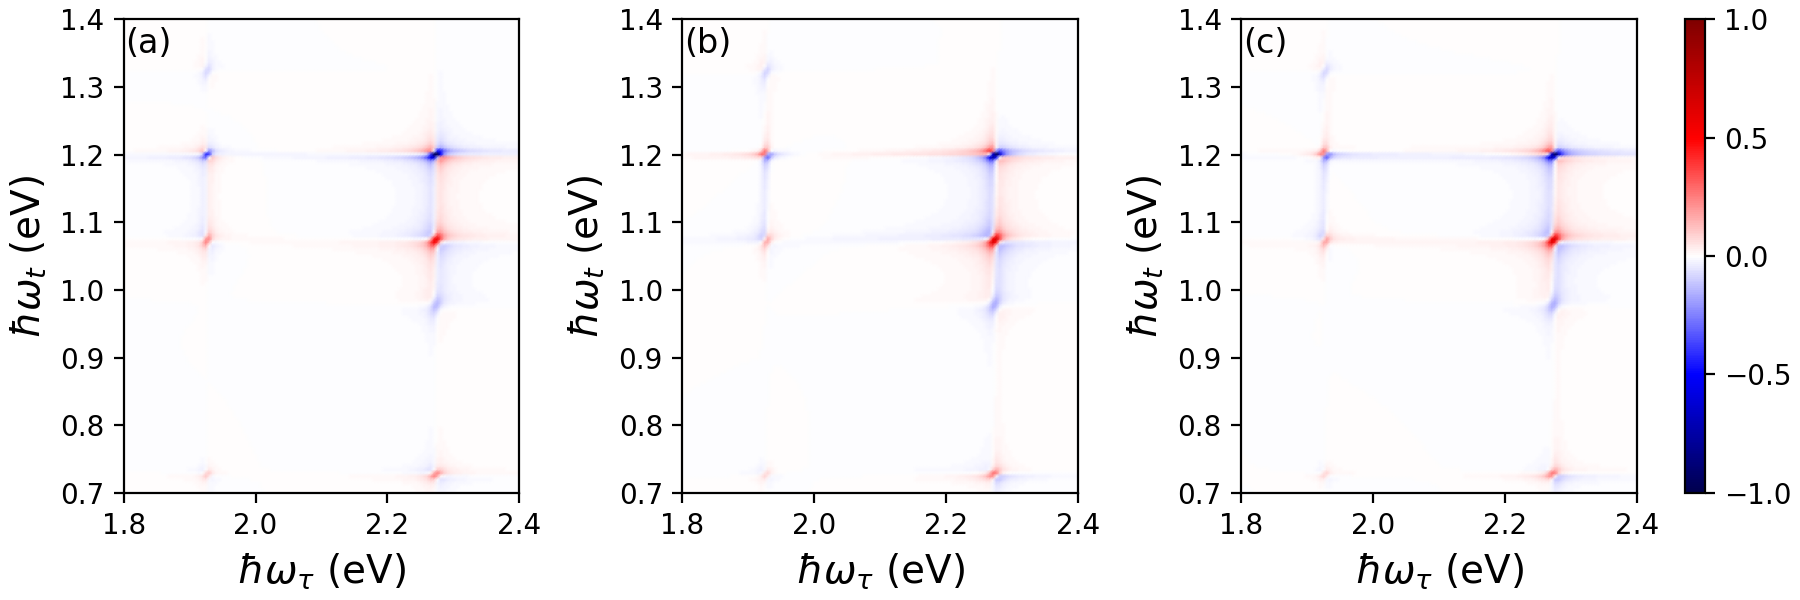

In [41]:
part = 'real'

peak_coords = (1.925,1.075)
box_size=8

T_val = 0/inverse_omega_0
T_ind,T_val = eei2d_true_imp.get_closest_index_and_value(T_val,T)
sig_open_true_imp = sig3D_true_imp[:,T_ind,:]
sig_open_5fs = sig3D_5fs[:,T_ind,:]
sig_open_5fs_time_ordered = sig3D_5fs_time_ordered[:,T_ind,:]

fig = plt.figure(constrained_layout=True,figsize=(9,3))
widths = [2, 2, 2, 0.1]
heights = [2]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths,
                          height_ratios=heights)
axes = []
for col in range(len(widths)):
    ax = fig.add_subplot(spec[0, col])
    axes.append(ax)
axa,axb,axc,axcb = axes


ufss.signals.plot2D(wtau_arr+2*c,wt_arr+1*c,sig_open_true_imp,part=part,
                    contours_only=False,norm='self',fig=fig,ax=axa,colorbar=False)

axa.set_ylim([0.7,1.4])
axa.set_xlim([1.8,2.4])
axa.set_xlabel(r'$\hbar\omega_\tau$ (eV)',fontsize=14)
axa.set_ylabel(r'$\hbar\omega_t$ (eV)',fontsize=14)
axa.text(1.803,1.35,'(a)',fontsize=12)

ufss.signals.plot2D(wtau_arr+2*c,wt_arr+1*c,sig_open_5fs_time_ordered,part=part,
                    contours_only=False,norm='self',fig=fig,ax=axb,colorbar=False)

axb.set_ylim([0.7,1.4])
axb.set_xlim([1.8,2.4])
axb.set_ylabel(r'$\hbar\omega_t$ (eV)',fontsize=14)
axb.set_xlabel(r'$\hbar\omega_\tau$ (eV)',fontsize=14)
axb.text(1.803,1.35,'(b)',fontsize=12)

ufss.signals.plot2D(wtau_arr+2*c,wt_arr+1*c,sig_open_5fs,part=part,
                    contours_only=False,norm='self',fig=fig,ax=axc,colorbar=True,
                   colorbar_ax = axcb,ticks=[-1,-0.5,0,0.5,1])

axc.set_ylim([0.7,1.4])
axc.set_xlim([1.8,2.4])
axc.set_xlabel(r'$\hbar\omega_\tau$ (eV)',fontsize=14)
axc.set_ylabel(r'$\hbar\omega_t$ (eV)',fontsize=14)
axc.text(1.803,1.35,'(c)',fontsize=12)

save_name = 'Suess2019Comparison_5fs_FWHM_T{:.2f}fs.png'.format(T_val*inverse_omega_0)

fig.savefig(os.path.join(folder,save_name))

As can be seen from this figure, although there are minor visual diffences between (a) Impulsive, (b) 5 fs time-ordered, and (c) 5 fs all diagrams, the impulsive calculation is a very good approximation of 5 fs Gaussian pulses.

<IPython.core.display.Javascript object>


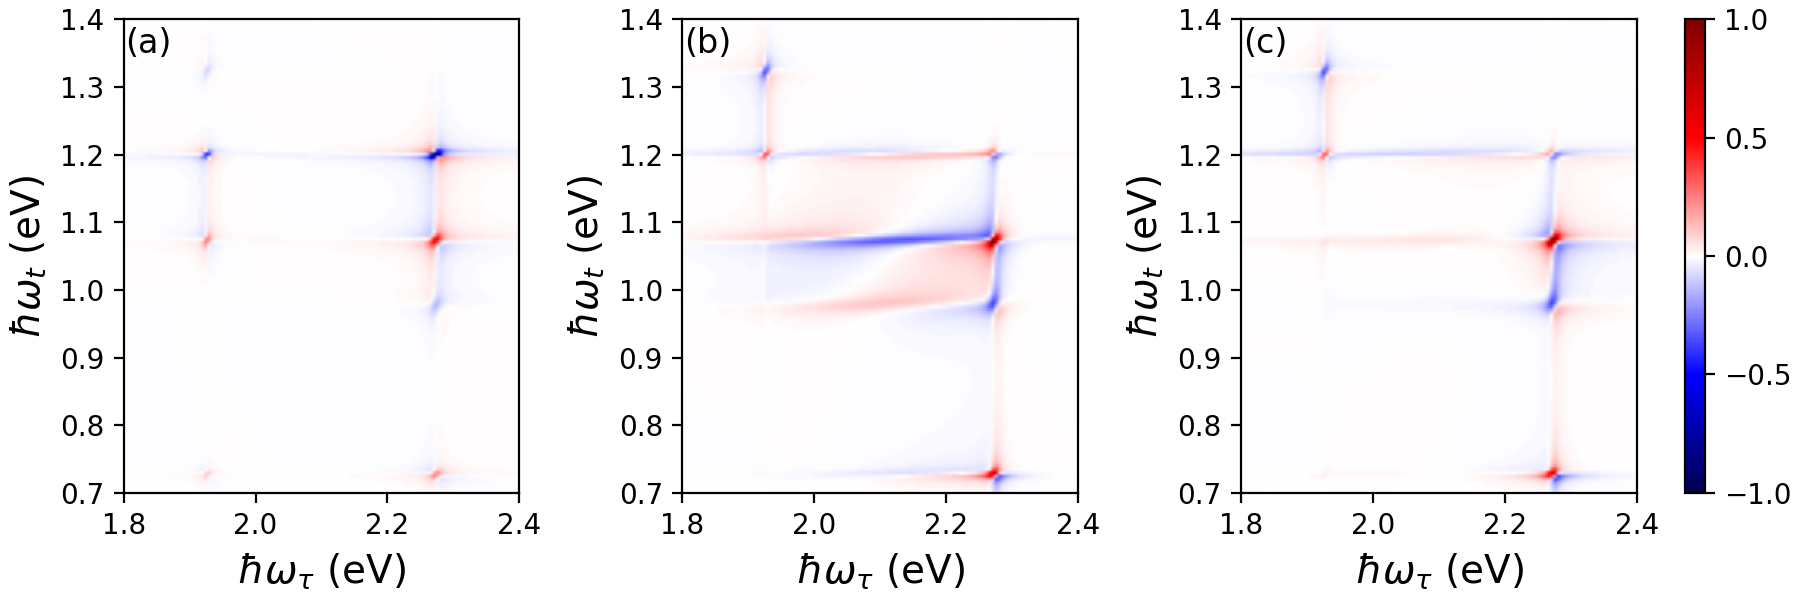

In [42]:
part = 'real'

peak_coords = (1.925,1.075)
box_size=8

T_val = 0/inverse_omega_0
T_ind,T_val = eei2d_true_imp.get_closest_index_and_value(T_val,T)
sig_open_true_imp = sig3D_true_imp[:,T_ind,:]
sig_open_15fs = sig3D_15fs[:,T_ind,:]
sig_open_15fs_time_ordered = sig3D_15fs_time_ordered[:,T_ind,:]

fig = plt.figure(constrained_layout=True,figsize=(9,3))
widths = [2, 2, 2, 0.1]
heights = [2]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths,
                          height_ratios=heights)
axes = []
for col in range(len(widths)):
    ax = fig.add_subplot(spec[0, col])
    axes.append(ax)
axa,axb,axc,axcb = axes


ufss.signals.plot2D(wtau_arr+2*c,wt_arr+1*c,sig_open_true_imp,part=part,
                    contours_only=False,norm='self',fig=fig,ax=axa,colorbar=False)

axa.set_ylim([0.7,1.4])
axa.set_xlim([1.8,2.4])
axa.set_xlabel(r'$\hbar\omega_\tau$ (eV)',fontsize=14)
axa.set_ylabel(r'$\hbar\omega_t$ (eV)',fontsize=14)
axa.text(1.803,1.35,'(a)',fontsize=12)

ufss.signals.plot2D(wtau_arr+2*c,wt_arr+1*c,sig_open_15fs_time_ordered,part=part,
                    contours_only=False,norm='self',fig=fig,ax=axb,colorbar=False)

axb.set_ylim([0.7,1.4])
axb.set_xlim([1.8,2.4])
axb.set_ylabel(r'$\hbar\omega_t$ (eV)',fontsize=14)
axb.set_xlabel(r'$\hbar\omega_\tau$ (eV)',fontsize=14)
axb.text(1.803,1.35,'(b)',fontsize=12)

ufss.signals.plot2D(wtau_arr+2*c,wt_arr+1*c,sig_open_15fs,part=part,
                    contours_only=False,norm='self',fig=fig,ax=axc,colorbar=True,
                   colorbar_ax = axcb,ticks=[-1,-0.5,0,0.5,1])

axc.set_ylim([0.7,1.4])
axc.set_xlim([1.8,2.4])
axc.set_xlabel(r'$\hbar\omega_\tau$ (eV)',fontsize=14)
axc.set_ylabel(r'$\hbar\omega_t$ (eV)',fontsize=14)
axc.text(1.803,1.35,'(c)',fontsize=12)

save_name = 'Suess2019Comparison_15fs_FWHM_T{:.2f}fs.png'.format(T_val*inverse_omega_0)

fig.savefig(os.path.join(folder,save_name))